# Portfolio analysis

## Case IV : Stock prices from NASDAQ Index

In [113]:
library('dplyr')
library('tidyr')
library('quadprog')
library('Sim.DiffProc')
library('ggplot2')
library('plotly')
options(repr.plot.width=16, repr.plot.height=8)

In [114]:
source('./PortfolioFunctions_v1.r')

In [120]:
stock_prices <- read.csv('./df_NASDAQ.csv')%>%
  mutate(Date=as.Date(Date,format = "%Y-%m-%d"))
head(stock_prices)

,Date,SLAB,FNLC,CVCO,BBI,FARM,NVCN,FARO,BBQ,OPTT,EXAS,SCOR,ATEC
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2008-01-03,36.49,14.63,29.39,301.7,23.09,90,27.24,12.76,3168,3.47,31.49,58.56
2,2008-01-04,34.75,14.58,29.53,298.9,22.50,90,25.26,12.19,2800,3.35,30.24,57.72
3,2008-01-07,33.59,14.75,29.27,298.9,22.42,90,24.65,11.90,2666,3.36,30.00,56.40
4,2008-01-08,31.96,14.43,28.65,299.6,21.32,90,23.58,11.64,2656,3.37,29.94,56.64
5,2008-01-09,31.35,14.16,31.85,297.5,21.74,90,22.25,11.39,2944,3.19,31.10,57.00
6,2008-01-10,31.30,14.48,31.31,295.4,22.43,110,23.18,11.55,2886,3.16,29.78,58.08


In [121]:
# get portfolio MV model
port.mv <- getPortfolio(base=stock_prices,year_to_start='2013',rebalance_period=24,mod='mv')

Estimated period : 2013-01 
Estimated period : 2015-01 
Estimated period : 2017-01 
Estimated period : 2019-01 
Estimated period : 2021-01 


In [122]:
# get portfolio MV-GBM model
port.mv_gbm <- getPortfolio(base=stock_prices,year_to_start='2013',rebalance_period=24,mod='gbm')

Estimated period : 2013-01 
Estimated period : 2015-01 
Estimated period : 2017-01 
Estimated period : 2019-01 
Estimated period : 2021-01 


In [123]:
#  Portfolio return
names <- c('date','MV','MV-GBM','MV-EW','MV-RW')
portfolio.ret <- data.frame('date' = port.mv$df.port.ret$date,
                       'MV'= port.mv$df.port.ret$min.ret,
                       'MV.GBM'= port.mv_gbm$df.port.ret$min.ret,
                       'MV.EW' = port.mv$df.port.ret$eqw.ret,
                       'MV.RW' = port.mv$df.port.ret$ran.ret)

In [124]:
# Cumulative portfolio
port.cum.ret <- portfolio.ret %>%
  mutate(cum.MV = cumsum(MV),
         cum.MV.GBM = cumsum(MV.GBM),
         cum.MV.EW = cumsum(MV.EW),
         cum.MV.RW = cumsum(MV.RW)) %>%
  dplyr::select(-MV,-MV.GBM,-MV.EW,-MV.RW)

In [125]:
# names
names2 <- c('date','MV-GBM minus MV','MV-GBM minus MV-EW','MV-GBM minus MV-RW')
cum.portfolio.diff <- port.cum.ret %>%
  mutate(MV.GBM_MV = cum.MV.GBM - cum.MV,
         MV.GBM_MV.EW =cum.MV.GBM - cum.MV.EW,
         MV.GBM_MV.RW = cum.MV.GBM - cum.MV.RW)%>%
  dplyr::select(-cum.MV,-cum.MV.GBM,-cum.MV.EW,-cum.MV.RW)

## colnames
colnames(portfolio.ret) <- names
colnames(port.cum.ret) <- names
colnames(cum.portfolio.diff) <- names2

In [126]:
# base cum.ret
base.cum.ret <- port.cum.ret %>%
  gather(key='Modelo',value='cumulative.return',-date)
# base cum.ret.diff
base.portfolio.diff <- cum.portfolio.diff %>%
  gather(key='Modelo',value='cumulative.return.diff',-date)

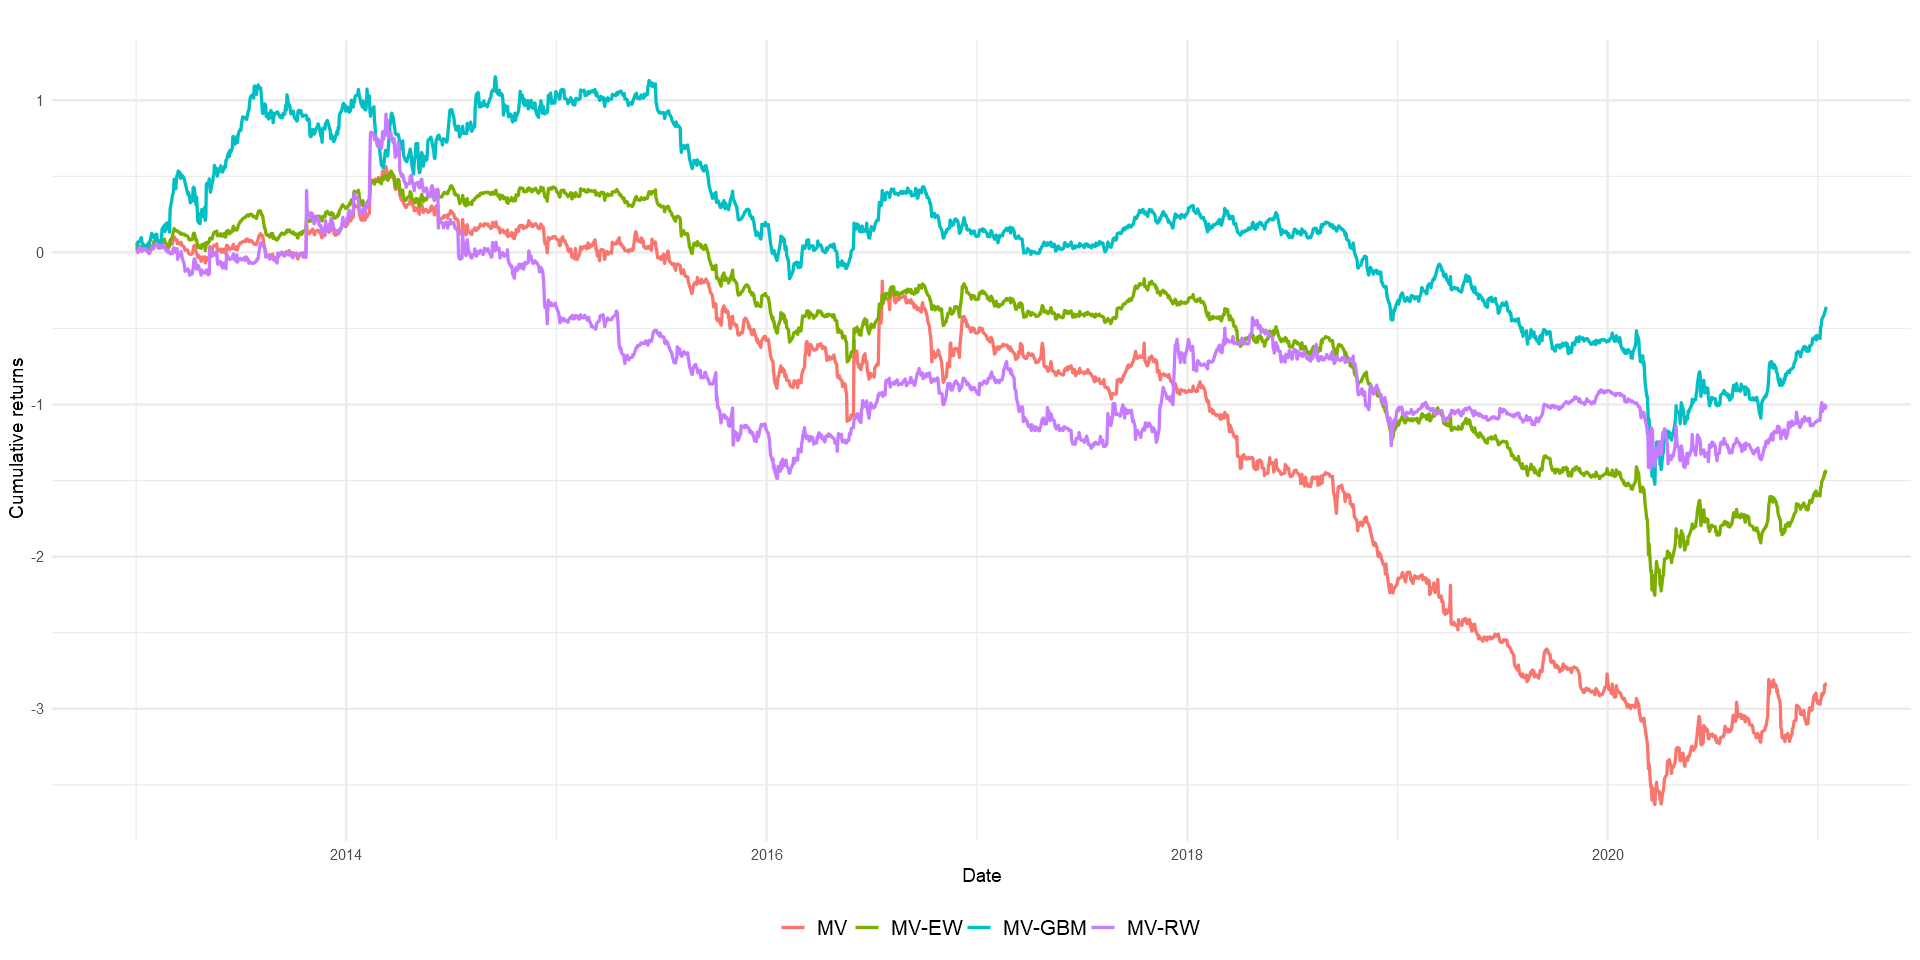

In [127]:
p0 <- ggplot(base.cum.ret , aes(x=date,y=cumulative.return,col=Modelo) )+
  geom_line(size=0.7) +
  theme_minimal() +
  theme(legend.position="bottom",
        legend.title = element_blank(),
        legend.text = element_text(colour="black", size=12)) +
  labs(title="",x='Date',y='Cumulative returns') 
p0

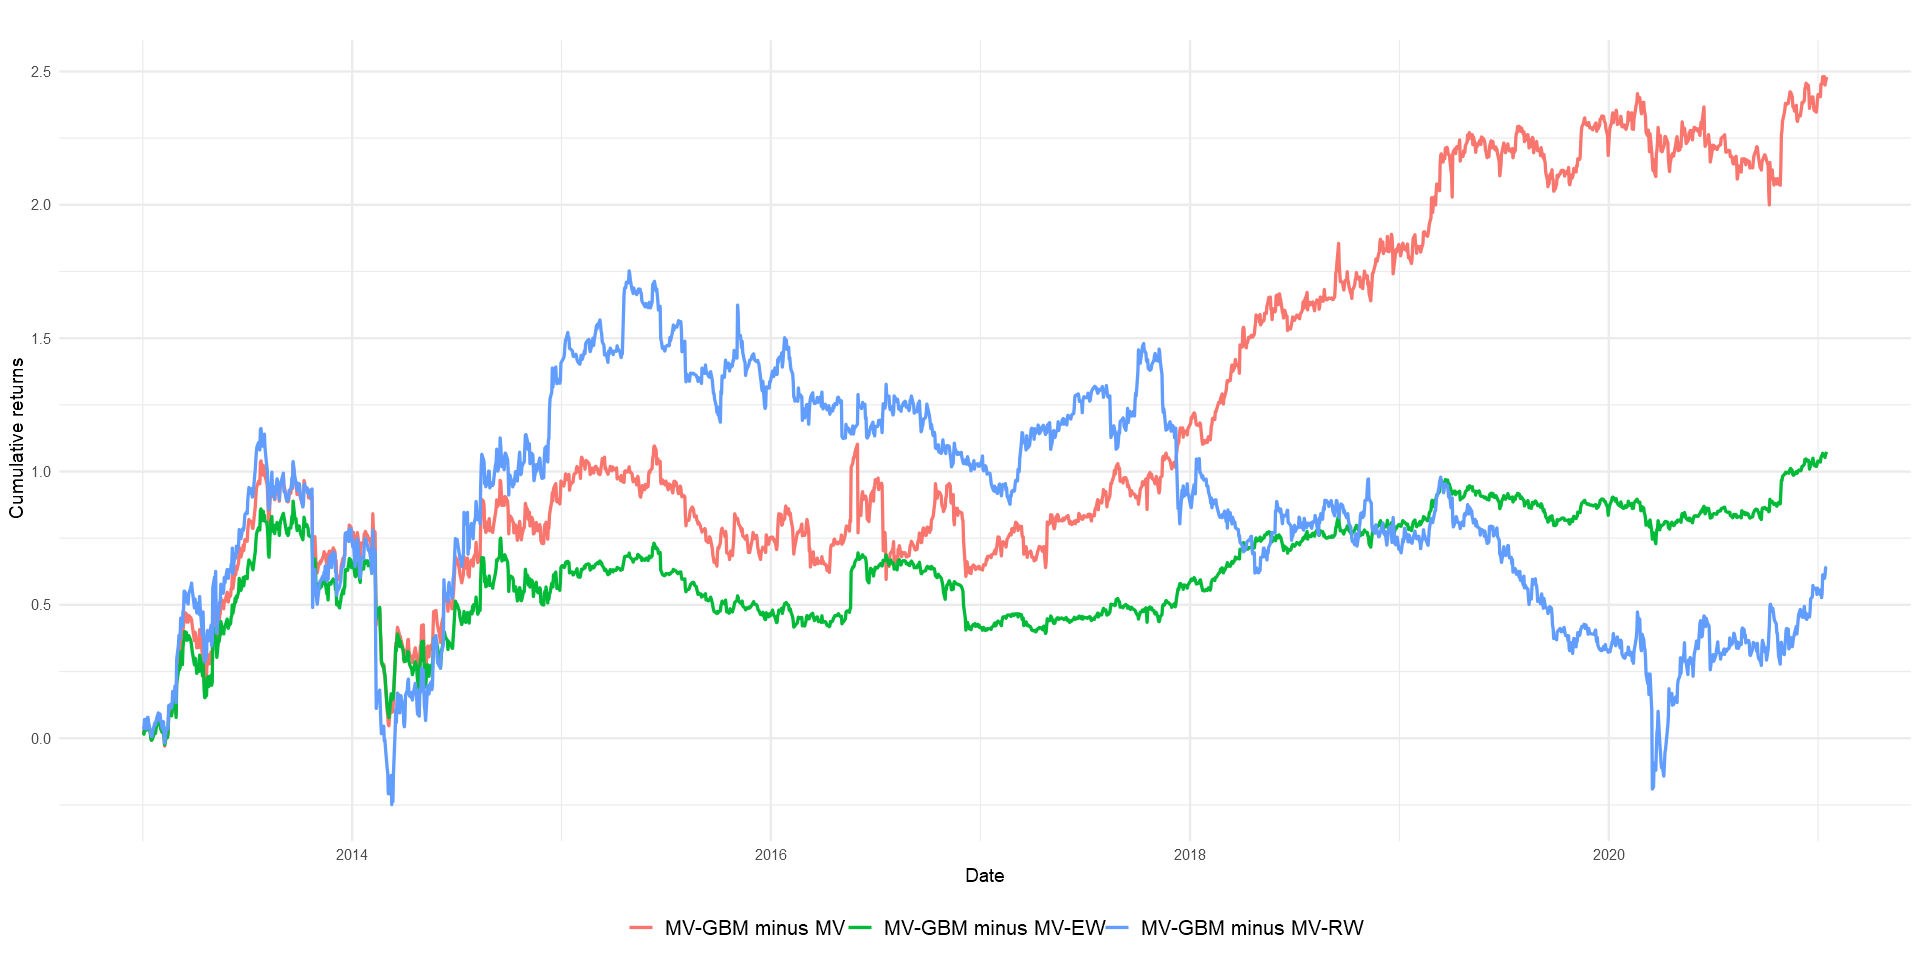

In [128]:
# differences
p1 <- ggplot(base.portfolio.diff , aes(x=date,y=cumulative.return.diff,col=Modelo) )+
  geom_line(size=0.7) +
  theme_minimal() +
  theme(legend.position="bottom",
        legend.title = element_blank(),
        legend.text = element_text(colour="black", size=12)) +
  labs(title="",x='Date',y='Cumulative returns') 
p1

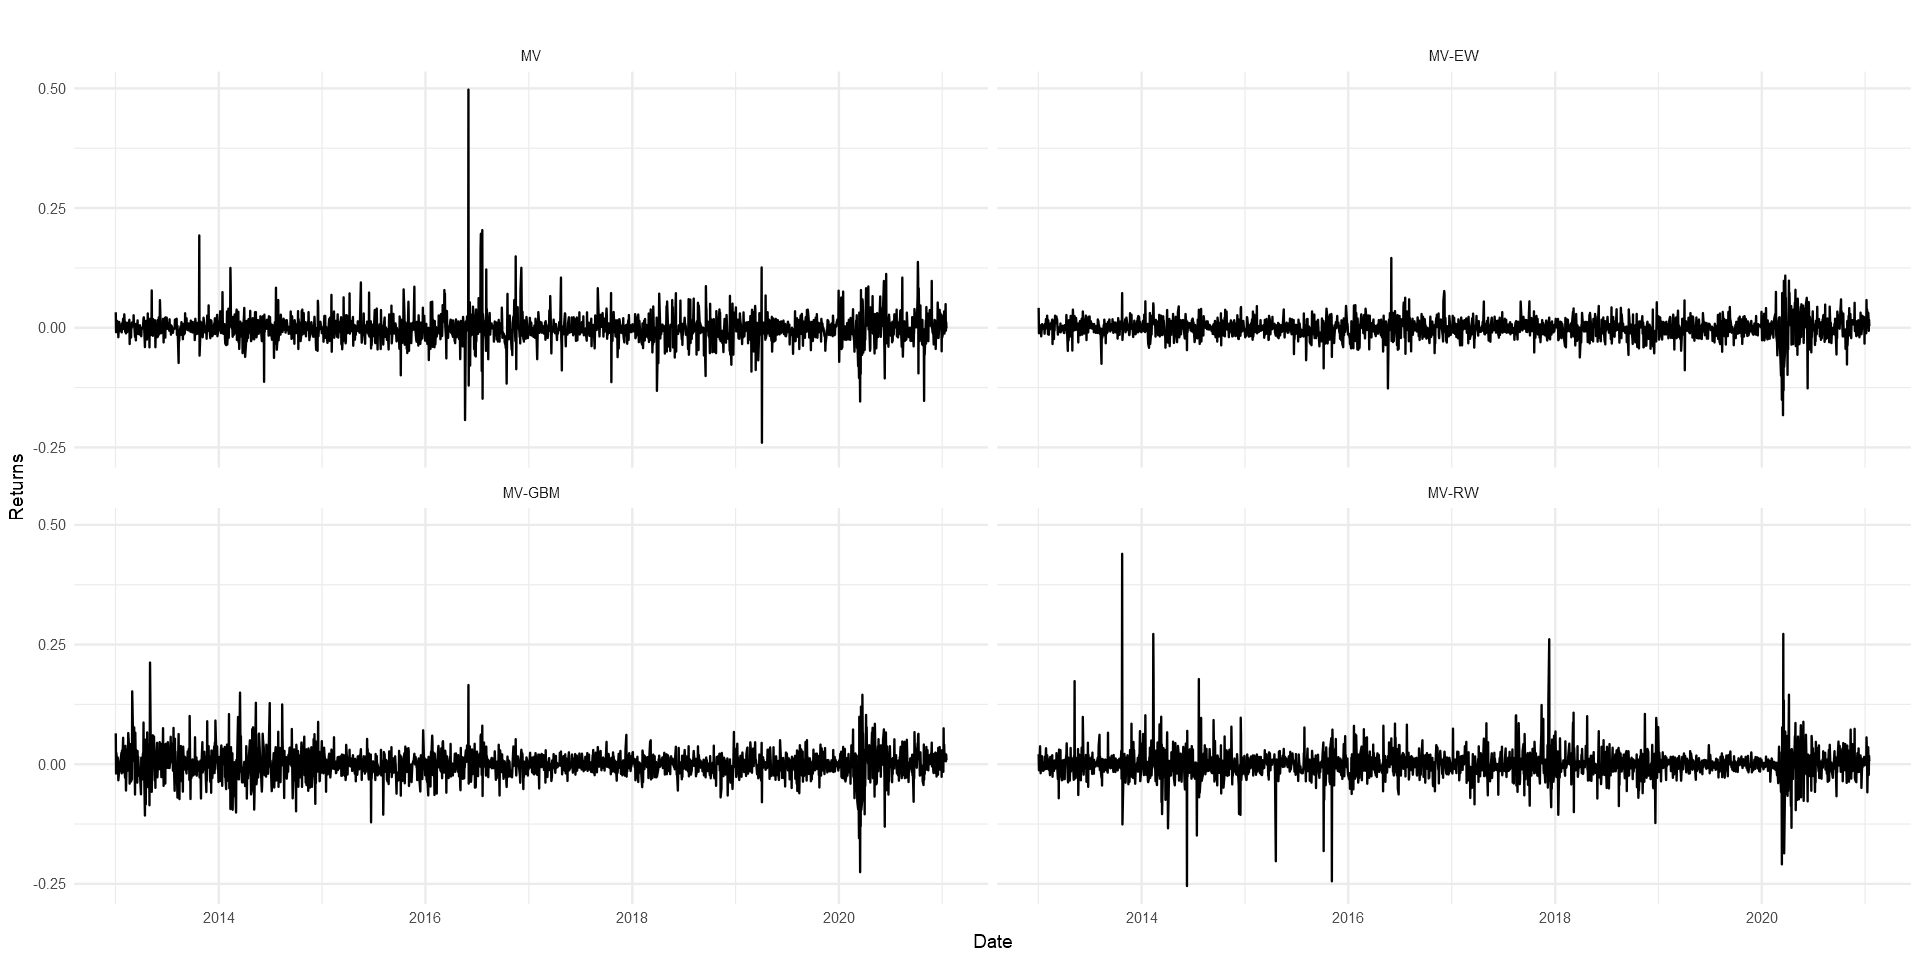

In [129]:
#  returns   
base.ret <- portfolio.ret %>%
  gather(key='Modelo',value='portfolio.return',-date)

# portfolio returns
p2 <- ggplot(base.ret , aes(x=date,y=portfolio.return) )+
  geom_line() +
  theme_minimal() +
  labs(title="",x='Date',y='Returns') +
  facet_wrap(vars(Modelo)) 
p2

In [130]:
# Global Sharpe ratio
mean_port <- base.ret %>% 
  group_by(Modelo) %>% 
  summarize(mean=mean(portfolio.return),
            sd = sd(portfolio.return),
            SharpeRatio = mean/sd) %>%
  ungroup() %>%
  data.frame() %>%
  arrange(desc(SharpeRatio))
mean_port

Modelo,mean,sd,SharpeRatio
<chr>,<dbl>,<dbl>,<dbl>
MV-GBM,-0.0001768364,0.02958743,-0.005976742
MV-RW,-0.0004942872,0.03405029,-0.014516388
MV-EW,-0.0007070491,0.02159302,-0.032744340
MV,-0.0014012474,0.03117476,-0.044948132


In [131]:
#  Sharpe Ratio df
sharpe.ratio <- portfolio.ret %>% 
  gather(key='Modelo',value='returns',-date) %>%
  mutate(year = substring(date,1,4)) %>% 
  dplyr::select(-date,Modelo,year,returns) %>%
  group_by(Modelo,year) %>%
  summarise(mean=mean(returns),sd=sd(returns)) %>%
  ungroup() %>%
  data.frame() %>%
  mutate(sharpe=mean/sd) %>%
  filter(year < '2021') 

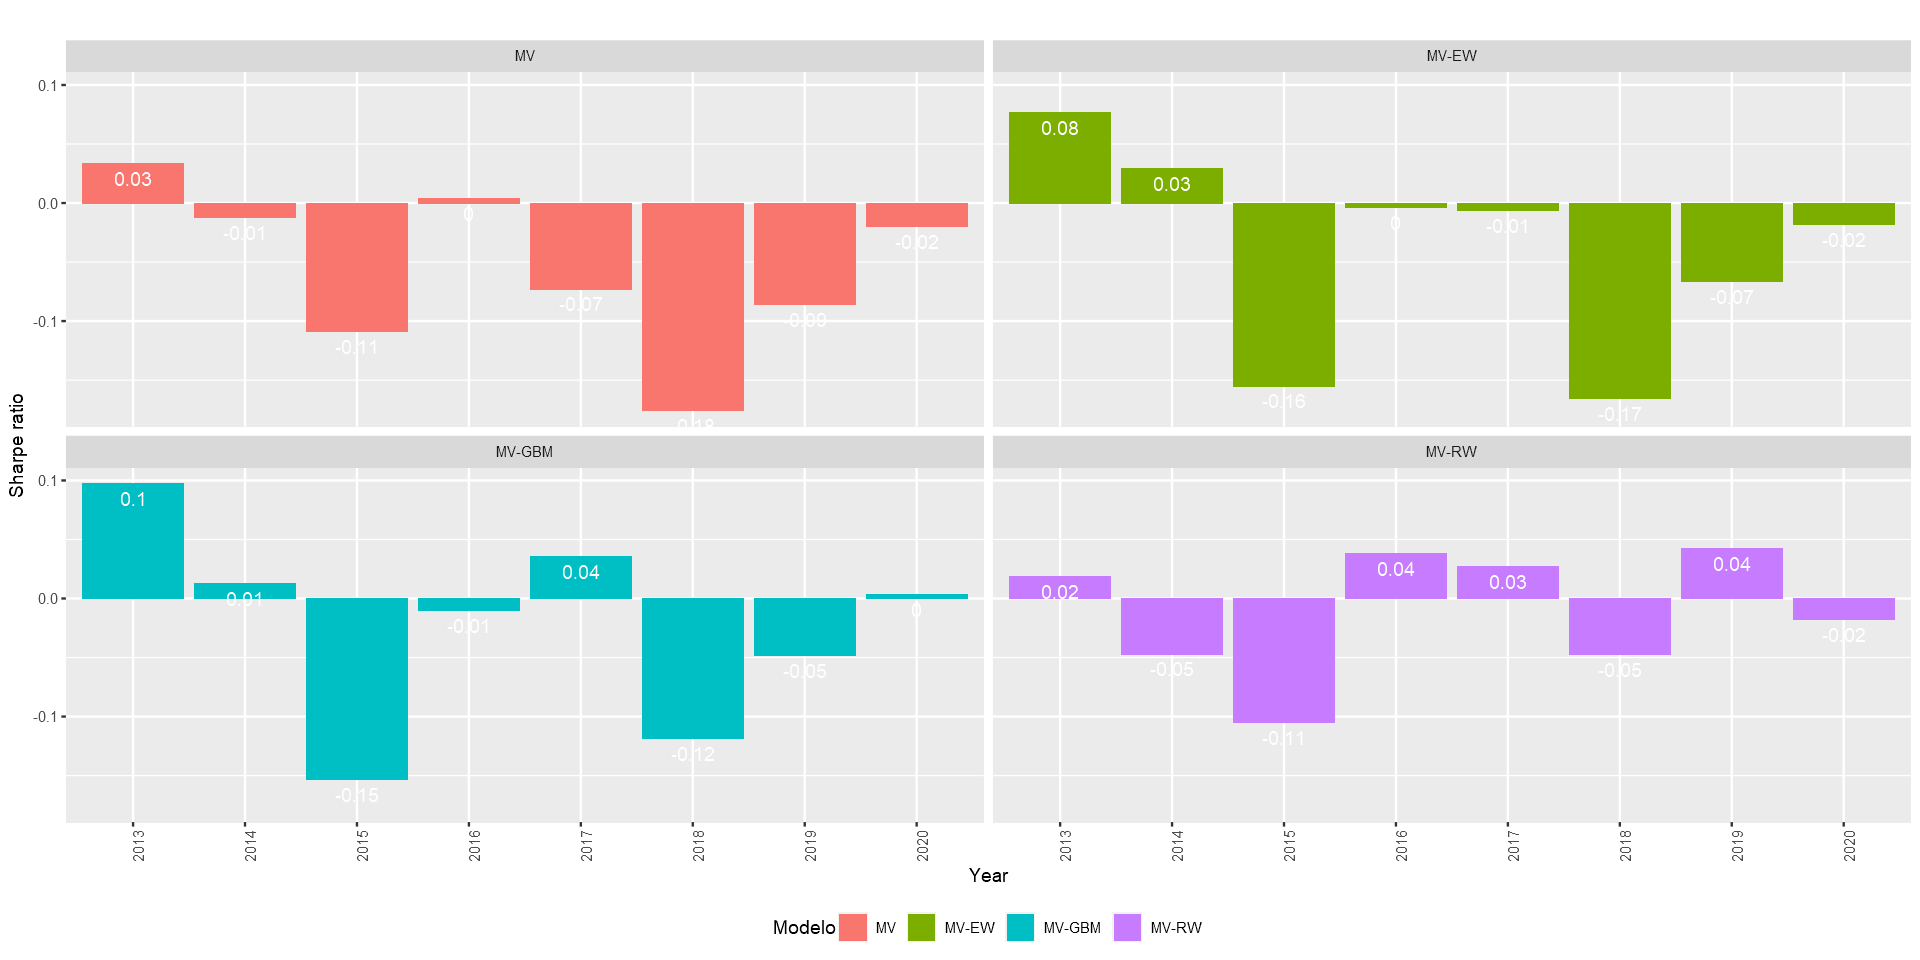

In [132]:
# Sharpe ratio plot
p4 <- ggplot(sharpe.ratio,aes(x=year,y=sharpe,fill=Modelo)) +
  geom_col(position=position_dodge()) +
  labs(title="",x='Year',y='Sharpe ratio') +
  facet_wrap(vars(Modelo)) +
  geom_text(aes(label=round(sharpe,2)), vjust=1.6, color="white", size=4) +
  theme(legend.position="bottom",
        axis.text.x = element_text(angle = 90))
  
p4

In [133]:
# Sharpe ratio table
sharpe.ratio.table <- portfolio.ret %>% 
  gather(key='Modelo',value='returns',-date) %>%
  mutate(year = substring(date,1,4)) %>%  # month = substring(date,6,7)
  dplyr::select(-date,Modelo,year,returns) %>%
  group_by(Modelo,year) %>%
  summarise(mean=mean(returns),sd=sd(returns)) %>%
  ungroup() %>%
  data.frame() %>%
  mutate(sharpe=mean/sd) %>%
  dplyr::select(-mean,-sd) %>%
  filter(year < '2021') %>%
  spread(key=Modelo,value=sharpe)
sharpe.ratio.table

year,MV,MV-EW,MV-GBM,MV-RW
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2013,0.033451852,0.077038408,0.097742509,0.01897498
2014,-0.012415344,0.028901952,0.012999331,-0.04698556
2015,-0.109167931,-0.155025681,-0.153385399,-0.10534087
2016,0.003703811,-0.004101442,-0.010311212,0.03818035
2017,-0.072858072,-0.006602816,0.035519866,0.02729331
2018,-0.175693374,-0.165562231,-0.118745717,-0.04718401
2019,-0.085741100,-0.066661186,-0.048431262,0.04210973
2020,-0.019932176,-0.018138065,0.003429021,-0.01758565


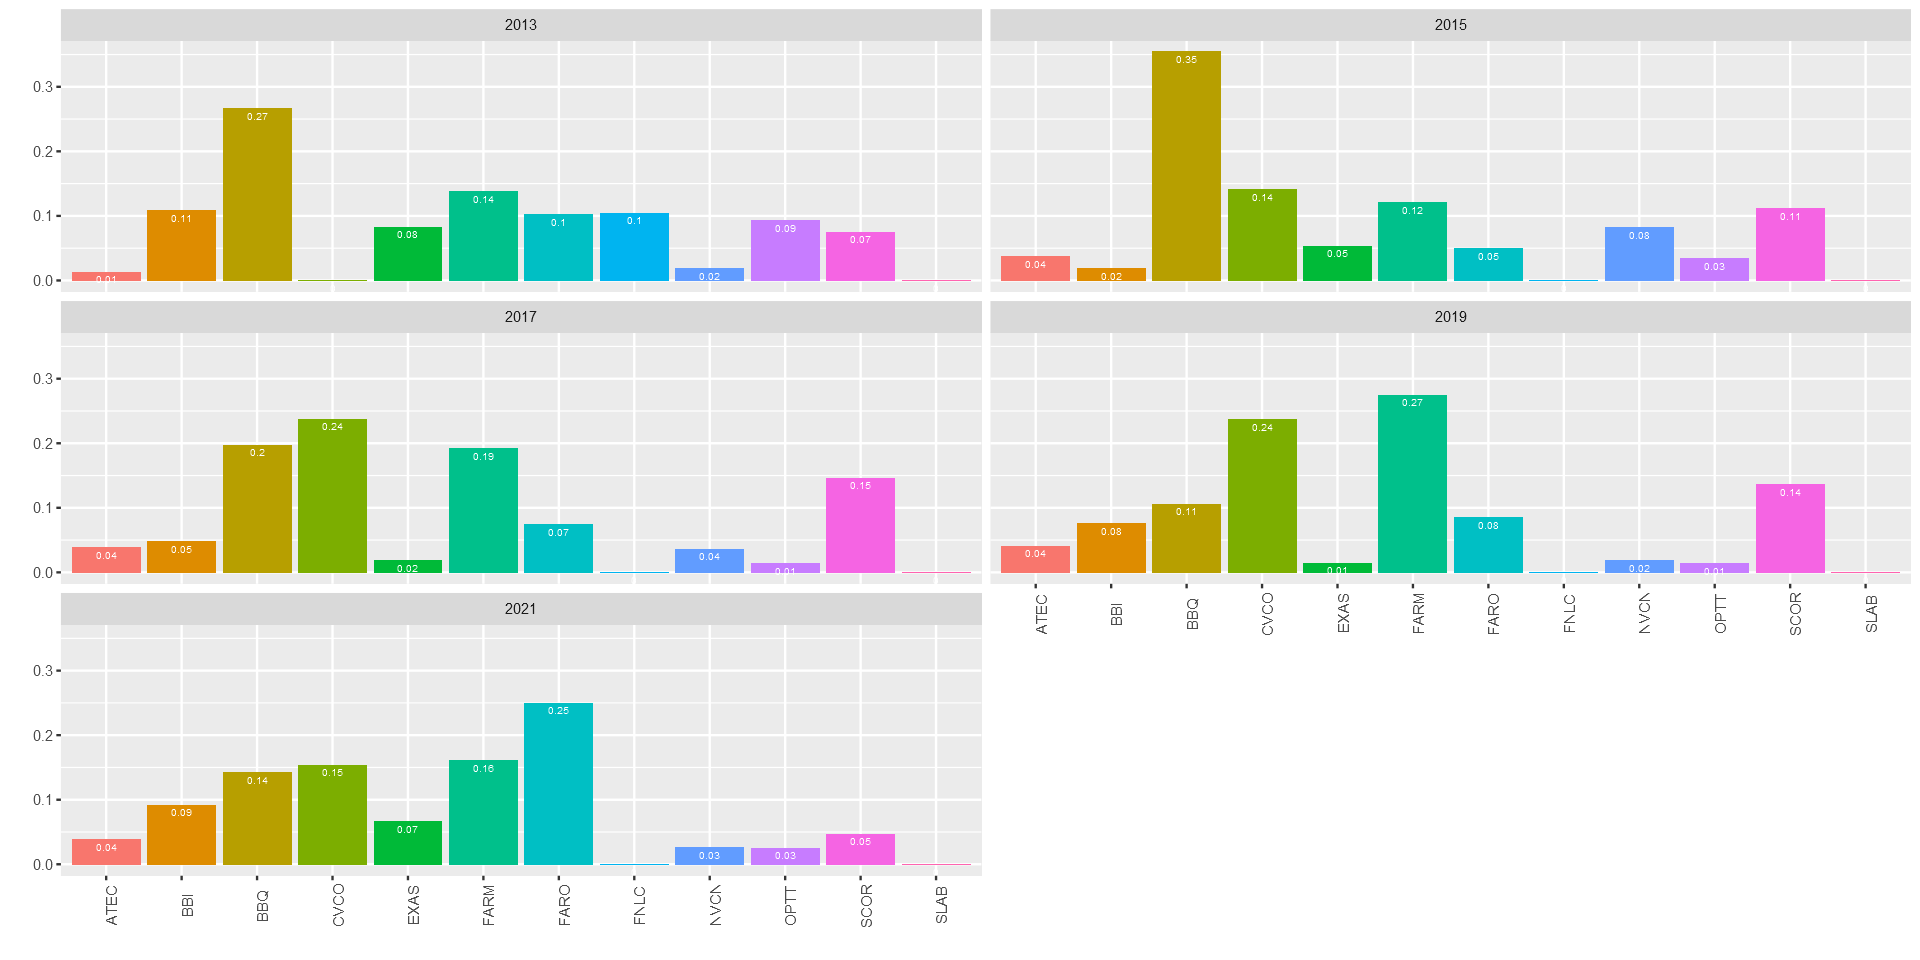

In [134]:
#  Weights
df_weights <- port.mv$df_min_weights %>%
  gather(key='asset',value='valor',-year) %>%
  mutate(year = substring(year,1,4)) 

p5 <- ggplot(df_weights,aes(x=asset,y=valor,fill=asset)) +
  geom_col(position=position_dodge()) +
  labs(x='',y='') +
  facet_wrap(vars(year),ncol=2) +
  geom_text(aes(label=round(valor,2)), vjust=1.6, color="white", size=2) +
  theme(legend.position="none",
        legend.title = element_blank(),
        axis.text.x = element_text(angle = 90))
p5

In [135]:
# weights for each rebalance period
df_weights <- port.mv$df_min_weights %>%
  gather(key='asset',value='valor',-year) %>%
  mutate(year = substring(year,1,4)) %>%
  spread(asset,valor)
df_weights

year,ATEC,BBI,BBQ,CVCO,EXAS,FARM,FARO,FNLC,NVCN,OPTT,SCOR,SLAB
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2013,0.0129,0.1078,0.2662,0.0000,0.0828,0.1381,0.1021,0.1044,0.0188,0.0922,0.0747,0
2015,0.0365,0.0182,0.3542,0.1408,0.0532,0.1203,0.0494,0.0000,0.0823,0.0333,0.1118,0
2017,0.0386,0.0471,0.1972,0.2375,0.0186,0.1919,0.0739,0.0000,0.0358,0.0132,0.1460,0
2019,0.0405,0.0759,0.1058,0.2364,0.0145,0.2745,0.0846,0.0000,0.0185,0.0136,0.1357,0
2021,0.0386,0.0916,0.1422,0.1538,0.0666,0.1606,0.2496,0.0000,0.0254,0.0250,0.0467,0
